In [17]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import netCDF4 as nc
import datetime as dt
import cmocean
import string
import glob
import pickle
import matplotlib as mpl
from salishsea_tools import evaltools as et
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')
from scipy.ndimage import gaussian_filter
from matplotlib.ticker import FormatStrFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
#from NorthNut import vvl_interp_T_to_V, vvl_interp_T_to_U;

%matplotlib inline

fluxes due to constant sinking rates (PON and bSi) can be calculated from daily mean concentrations

In [18]:
SOGtmaskPath='../../save/SOGtmask.pkl'
(tmaskSOG,ig0,ig1,jg0,jg1)=pickle.load(open(SOGtmaskPath,'rb'))

In [19]:
tmaskSOG.shape,ig0

((1, 40, 898, 398), 110)

In [20]:
SOGmask=tmaskSOG[:,:,jg0:jg1,ig0:ig1]
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    A=np.expand_dims(fm.variables['e1t'][:,jg0:jg1,ig0:ig1]*fm.variables['e2t'][:,jg0:jg1,ig0:ig1],0)

In [21]:
np.shape(A)

(1, 1, 515, 288)

In [22]:
# create mask for bottom concentration values
dcmask=np.zeros_like(SOGmask)
dcmask[:,:-1,:,:]=SOGmask[:,:-1,:,:]-SOGmask[:,1:,:,:]
np.shape(dcmask)

(1, 40, 515, 288)

In [23]:
t0=dt.datetime(2015,1,1) # originally 5/15-8/15,  but changed to even number of fortnights (6, end is included)
te=dt.datetime(2015,12,31)
mod_basedir='/data/eolson/results/MEOPAR/SS36runs/linkHC201812/'
mod_nam_fmt='nowcast'
mod_flen=1
saveloc='../../save/'
fver='HC201812'
fformat0='%Y%m%d'

In [24]:
flistB=et.index_model_files(t0,te,mod_basedir,mod_nam_fmt,mod_flen,'ptrc_T',24)
#flistT=et.index_model_files(t0,te,mod_basedir,mod_nam_fmt,mod_flen,'grid_T',1)

In [25]:
flistB['paths'][0]

'/data/eolson/results/MEOPAR/SS36runs/linkHC201812/01jan15/SalishSea_1d_20150101_20150101_ptrc_T.nc'

In [26]:
zz_w_sink_D_PON = 1.0e-4      # m/s PON detritus sinking rate # Jeffery quoting Dune and Bacon
zz_w_sink_D_bSi = 1.3e-4      # m/s  biogenic silicon detritus sinking rate # match NO3 particles
zz_alpha_b_Si = 0.8          # fraction of bottom flux resuspended in bottom cell
zz_alpha_b_N = 0.45          # fraction of bottom flux resuspended in bottom cell

# for diatoms:
#zz_w_sink_Pmicro_min = 0.5  # m/d  microphyto minimum sinking rate # Alain CONVERTED TO M/S ON NAMELIST READ
#zz_w_sink_Pmicro_max = 1.2  # m/d microphyto maximum sinking rate # Alain CONVERTED TO M/S ON NAMELIST READ
# diatom nut lim params:
#zz_rate_K_Si=1.2
#zz_rate_kapa=1.0
#zz_rate_k=2.0
#              zz_Pmicro_w_sink(ji,jj,jk) = zz_w_sink_Pmicro_min * zz_micro_Nlimit(ji,jj,jk) &
#                  + zz_w_sink_Pmicro_max * (1.0_wp - zz_micro_Nlimit(ji,jj,jk))
#  w_diat = zz_w_sink_Pmicro_min*diatNutLim[:,:,:,:]+zz_w_sink_Pmicro_max*(1.0-diatNutLim[:,:,:,:])
#    microNlim[:,:,:,:]=
#            nutLim=bio_tools.calc_nutLim(zz_NO,zz_NH,zz_Si,zz_rate_K_Si,zz_rate_kapa,zz_rate_k)
# *** check that get same result from (zz_I_par,zz_NO,zz_NH,zz_Si,tmask,
#  zz_rate_Iopt,zz_rate_gamma,zz_rate_K_Si,zz_rate_kapa,zz_rate_k)=each_limiter(zz_I_par,zz_NO,zz_NH,zz_Si,tmask,
#                 zz_rate_Iopt,zz_rate_gamma,zz_rate_K_Si,zz_rate_kapa,zz_rate_k)
#                  diatNutLim[...] = nutLim**0.2
#      wsink=bio_tools.calc_diat_sink(wsinkmin,wsinkmax,diatNutLim)
#for all:
#                  zz_flux(ji,jj,jk) = - zz_w_sink(ji,jj,jk) * zz_qty(ji,jj,jk) * &
#                          & ((1-zz_alpha_b)*tmask(ji,jj,jk)+zz_alpha_b*tmask(ji,jj,jk+1))
#              dcmask = tmask(ji,jj,jk) - tmask(ji,jj,jk+1)=tmask-tmaskp
#             flux= -w C (tmask -alpha*tmask + alpha*tmaskp) = -w C (tmask-alpha*dcmask) = - dcmask w C (1-alpha)
#  m/s*mmol/m3=mmol/m2/s; multiply by 1e-3*A*24*3600 to get mol/d
#SOGmask24=np.tile(SOGmask,(24,1,1,1))

In [27]:
sink=dict()
tr={'PON':'particulate_organic_nitrogen', 
    'BSI':'biogenic_silicon'}
alpha={'PON':zz_alpha_b_N, 
    'BSI':zz_alpha_b_Si}
ws={'PON':zz_w_sink_D_PON, 
    'BSI':zz_w_sink_D_bSi}
for el in tr.keys():
    sink[el]=np.empty((int((te-t0).days+1),))

In [28]:
times=[t0+dt.timedelta(days=ii) for ii in range(0,int((te-t0).total_seconds()/3600/24)+1)]
## calculations
for iif in range(0,len(flistB)):
    print(iif,dt.datetime.now())
    li0=iif*mod_flen
    li1=(iif+1)*mod_flen
    with nc.Dataset(flistB.loc[iif,['paths']].values[0]) as fB:
        for ili0 in range(0,mod_flen): # mod_flen is number of days in file, in case calc on other runs
            for el in tr.keys():
                sink[el][ili0+li0]=1e-3*24*3600*(1.0-alpha[el])*ws[el]*\
                                np.sum(A*dcmask*fB.variables[tr[el]][ili0,:,jg0:jg1,ig0:ig1])

0 2020-02-12 16:53:40.634213
1 2020-02-12 16:53:41.233648
2 2020-02-12 16:53:41.849974
3 2020-02-12 16:53:42.499288
4 2020-02-12 16:53:43.154527
5 2020-02-12 16:53:43.756522
6 2020-02-12 16:53:44.342568
7 2020-02-12 16:53:44.957523
8 2020-02-12 16:53:45.591088
9 2020-02-12 16:53:46.221799
10 2020-02-12 16:53:46.831560
11 2020-02-12 16:53:47.449167
12 2020-02-12 16:53:48.084461
13 2020-02-12 16:53:48.716202
14 2020-02-12 16:53:49.294078
15 2020-02-12 16:53:49.875081
16 2020-02-12 16:53:50.536717
17 2020-02-12 16:53:51.152001
18 2020-02-12 16:53:51.789422
19 2020-02-12 16:53:52.416803
20 2020-02-12 16:53:53.054885
21 2020-02-12 16:53:53.677503
22 2020-02-12 16:53:54.286134
23 2020-02-12 16:53:54.860259
24 2020-02-12 16:53:55.476445
25 2020-02-12 16:53:56.061519
26 2020-02-12 16:53:56.669781
27 2020-02-12 16:53:57.314211
28 2020-02-12 16:53:57.919068
29 2020-02-12 16:53:58.539345
30 2020-02-12 16:53:59.175976
31 2020-02-12 16:53:59.799506
32 2020-02-12 16:54:00.434983
33 2020-02-12 16:54:

268 2020-02-12 16:56:27.499117
269 2020-02-12 16:56:28.103935
270 2020-02-12 16:56:28.709411
271 2020-02-12 16:56:29.328716
272 2020-02-12 16:56:29.956931
273 2020-02-12 16:56:30.603547
274 2020-02-12 16:56:31.227301
275 2020-02-12 16:56:31.836843
276 2020-02-12 16:56:32.460683
277 2020-02-12 16:56:33.093048
278 2020-02-12 16:56:33.718953
279 2020-02-12 16:56:34.353316
280 2020-02-12 16:56:34.963296
281 2020-02-12 16:56:35.566235
282 2020-02-12 16:56:36.168750
283 2020-02-12 16:56:36.762824
284 2020-02-12 16:56:37.364517
285 2020-02-12 16:56:37.961834
286 2020-02-12 16:56:38.582130
287 2020-02-12 16:56:39.189955
288 2020-02-12 16:56:39.814437
289 2020-02-12 16:56:40.425910
290 2020-02-12 16:56:41.028627
291 2020-02-12 16:56:41.652360
292 2020-02-12 16:56:42.287219
293 2020-02-12 16:56:42.900900
294 2020-02-12 16:56:43.527257
295 2020-02-12 16:56:44.124570
296 2020-02-12 16:56:44.725943
297 2020-02-12 16:56:45.332197
298 2020-02-12 16:56:45.944971
299 2020-02-12 16:56:46.545314
300 2020

In [13]:
times=np.array(times)
csinkPath='../../save/SOGsinkPONbSi'+t0.strftime(fformat0)+'-'+te.strftime(fformat0)+'.pkl'
pickle.dump((times,sink),open(csinkPath,'wb'))

In [14]:
(times,sink)=pickle.load(open(csinkPath,'rb'))

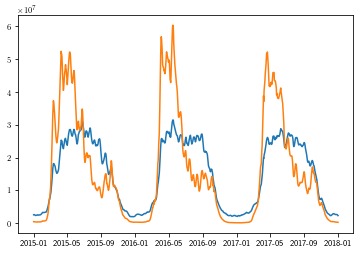

In [15]:
for el in sink.keys():
    plt.plot(times,sink[el])

In [16]:
sink

{'PON': array([2524175.66032914, 2574998.87838861, 2581442.43518255, ...,
        2490131.63316799, 2365504.92749349, 2276950.87542911]),
 'BSI': array([419789.81663141, 414427.68999134, 406240.99843738, ...,
        269596.45021037, 244800.34736537, 226800.921161  ])}